In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
mnist=MNIST(root='data',train=True,download=False,transform=Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5,))]))

In [3]:
img,label=mnist[0]
print('Label: ',label)
print(img[:,10:15,10:15])
torch.min(img),torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
    out=(x+1)/2
    return out.clamp(0,1)

Label:  5


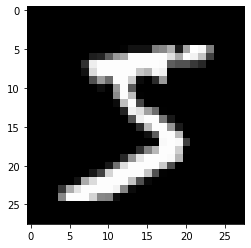

In [5]:
img_norm=denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label: ',label)

In [6]:
batch_size=100
data_loader=DataLoader(mnist,batch_size,shuffle=True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([9, 8, 9, 6, 8, 9, 4, 4, 1, 2, 9, 3, 2, 0, 4, 1, 5, 5, 7, 5, 1, 3, 2, 0,
        7, 3, 1, 5, 9, 3, 6, 3, 4, 7, 8, 2, 4, 0, 2, 2, 1, 3, 2, 3, 1, 2, 3, 6,
        5, 2, 0, 2, 4, 5, 1, 2, 4, 0, 8, 8, 9, 8, 2, 4, 1, 1, 0, 3, 6, 1, 8, 5,
        8, 6, 9, 3, 4, 8, 2, 8, 7, 3, 0, 1, 6, 4, 1, 5, 5, 5, 9, 1, 7, 6, 9, 2,
        2, 1, 5, 9])


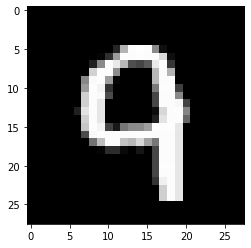

In [7]:
for img_batch, label_batch in data_loader:
    print('First Batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0],cmap='gray')
    print(label_batch)
    break

In [8]:
device=torch.device('cuda'if torch.cuda.is_available() else 'gpu')
device

device(type='cuda')

In [9]:
image_size=784
hidden_size=256

In [10]:
D=nn.Sequential(nn.Linear(image_size,hidden_size),nn.LeakyReLU(0.2),nn.Linear(hidden_size,hidden_size),nn.LeakyReLU(0.2),nn.Linear(hidden_size,1),nn.Sigmoid())

In [11]:
D.to(device);

In [12]:
latent_size=64

In [13]:
G=nn.Sequential(nn.Linear(latent_size,hidden_size),nn.ReLU(),nn.Linear(hidden_size,hidden_size),nn.ReLU(),nn.Linear(hidden_size,image_size),nn.Tanh())

In [14]:
y=G(torch.randn(2,latent_size))
gen_imgs=denorm(y.reshape((-1,28,28)).detach())

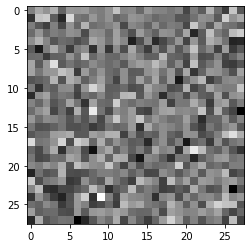

In [15]:
plt.imshow(gen_imgs[0],cmap='gray')

In [16]:
G.to(device);

In [18]:
criterion=nn.BCELoss()
d_optimizer=torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels=torch.ones(batch_size,1).to(device)
    fake_labels=torch.zeros(batch_size,1).to(device)

    outputs=D(images)
    d_loss_real=criterion(outputs,real_labels)
    real_score=outputs
    z=torch.randn(batch_size,latent_size).to(device)
    fake_images=G(z)
    outputs=D(fake_images)
    d_loss_fake=criterion(outputs,fake_labels)
    fake_score=outputs
    d_loss=d_loss_real+d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss,real_score,fake_score




In [20]:
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [21]:
z=torch.randn(batch_size,latent_size).to(device)